# Atividade 1 - Séries temporais

Utilizando o conjunto de dados `dados_clima.csv`:

* Modifique o shape de entrada para se adequar a rede neural.
* Monte uma rede neural RNN para predicao.
* Modifique essa rede neural para utilizar uma camada LSTM.

Mostre o RMSE da predicao.

**Vamos utilizar como coluna-alvo a temperatura máxima (`tmax`).**


## Objetivo

Prever a temperatura máxima para os próximos 7 dias nas diferentes cidades presentes no dataset.

## Treino e teste

Considerando o objetivo, é importante separar o dataset em treino e teste considerando as datas, não coletando aleatoriamente.

Sendo assim, vamos separar os últimos 7 dias dos dados como dados de teste.

Além disso, neste primeiro momento vamos considerar somente dados a partir de 2013 para nossos experimentos, pois o tempo de treinamento está muito longo. Podemos utilizar o conjunto inteiro de dados posteriormente, testando nos melhores modelos.

# Bibliotecas

In [42]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.context('bmh')

import tensorflow as tf
tf.__version__ #Talvez seja necessário instalar tensorflow 2 antes de iniciar esse notebook
#Adicione a sua arquitetura, lembrando que a entrada tem tamanho maxlen e a saída 2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import gc

In [43]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the fourth GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Dados

In [44]:
clima = pd.read_csv('dados_clima.csv')
print('Dataset com {} linhas e {} colunas.'.format(clima.shape[0], clima.shape[1]))

Dataset com 214166 linhas e 13 colunas.


In [45]:
clima.head()

,Estacao,altitude,cidade,data,estado,fonte,insolacao,latitude,longitude,precipitacao,tmax,tmin,ur
0,83552,130.0,corumba,01/01/2000,ms,inpe,9.8,-19.01,-57.65,NaN,32.9,NaN,64.50
1,83552,130.0,corumba,02/01/2000,ms,inpe,12.4,-19.01,-57.65,1.2,33.6,24.4,59.25
2,83552,130.0,corumba,03/01/2000,ms,inpe,12.3,-19.01,-57.65,0.0,35.6,21.5,60.75
3,83552,130.0,corumba,04/01/2000,ms,inpe,12.4,-19.01,-57.65,0.0,37.2,23.8,58.75
4,83552,130.0,corumba,05/01/2000,ms,inpe,12.2,-19.01,-57.65,0.0,37.4,23.7,57.25


In [46]:
print('Quantidade de estados: {}.'.format(clima.estado.nunique()))
print('Quantidade de cidades: {}.'.format(clima.cidade.nunique()))
print('Quantidade de estações: {}.'.format(clima.Estacao.nunique()))

Quantidade de estados: 3.
Quantidade de cidades: 31.
Quantidade de estações: 32.


In [47]:
print('Estados no dataset:')
print(clima.estado.unique())

Estados no dataset:
['ms' 'pr' 'sp']


In [48]:
print('Quantidade de fontes de dados: {}.'.format(clima.fonte.nunique()))

Quantidade de fontes de dados: 2.


In [49]:
clima.fonte.value_counts()

inpe     162845
iapar     51321
Name: fonte, dtype: int64

In [50]:
clima.isnull().sum()

Estacao            0
altitude           0
cidade             0
data               0
estado             0
fonte              0
insolacao       2215
latitude           0
longitude          0
precipitacao       1
tmax               0
tmin               1
ur                 0
dtype: int64

Vamos substituir os dados faltantes pela mediana. Os principais dados faltantes são de insolação, enquanto dados de temperatura e precipitação tem somente um dado faltante em cada.

In [51]:
clima.insolacao.fillna(clima.insolacao.median(), inplace=True)
clima.precipitacao.fillna(clima.precipitacao.median(), inplace=True)
clima.tmin.fillna(clima.tmin.median(), inplace=True)

# Preparando os dados
Em um primeiro momento vamos construir um modelo simples de MLP, que servirá como baseline para os próximos modelos.

Vamos seguir algumas etapas na construção da base de dados:

* Transformação das variáveis categóricas;
* Separação em treino e teste;
* Transformação do dataframe em numpy array;
* Normalização dos dados.

In [52]:
# Transformando a coluna de data
clima.loc[:, 'data'] = pd.to_datetime(clima.data, format="%d/%m/%Y")

### Transformação das variáveis categóricas

Para a transformação será utilizada one hot encoding, através do método `get_dummies` do Pandas.

A coluna `Estacao` foi transformada em string, pois o método `get_dummies` aceita somente strings para as variáveis categoricas.

In [53]:
# Colunas categóricas
cat_cols = ['Estacao', 'cidade', 'estado', 'fonte' ]
# Transforma coluna em string
clima.loc[:, 'Estacao'] = clima.Estacao.astype(str)
# Aplica o one hot
one_hot = pd.get_dummies(clima[cat_cols])
# Dropa as colunas antigas
clima.drop(cat_cols, axis=1, inplace=True)
# Adiciona o df com one hot encoding ao dataframe original
clima = clima.join(one_hot)
data = clima.copy()
data.index = data.data
del one_hot
gc.collect()

5214

In [54]:
data.head()

,altitude,data,insolacao,latitude,longitude,precipitacao,tmax,tmin,ur,Estacao_2350018,Estacao_2351003,Estacao_2352017,Estacao_2353008,Estacao_2550025,Estacao_2551010,Estacao_2653012,Estacao_83075,Estacao_83513,Estacao_83552,Estacao_83565,Estacao_83623,Estacao_83630,Estacao_83669,Estacao_83676,Estacao_83702,Estacao_83704,Estacao_83714,Estacao_83716,Estacao_83726,Estacao_83766,Estacao_83767,Estacao_83773,Estacao_83781,Estacao_83783,Estacao_83784,Estacao_83811,Estacao_83813,Estacao_83836,Estacao_83842,Estacao_83844,Estacao_83851,cidade_avare,cidade_bandeirantes,cidade_campomourao,cidade_camposdojordao,cidade_castro,cidade_catanduva,cidade_corumba,cidade_curitiba,cidade_fernandespinheiro,cidade_franca,cidade_franciscobeltrao,cidade_guarapuava,cidade_guarulhos,cidade_irati,cidade_ivai,cidade_ivinhema,cidade_londrina,cidade_maringa,cidade_nhecolandia,cidade_paranagua,cidade_paranaiba,cidade_paranavai,cidade_pontapora,cidade_presidenteprudente,cidade_saocarlos,cidade_saopaulo,cidade_saosimao,cidade_sorocaba,cidade_taubate,cidade_umuarama,cidade_votuporanga,estado_ms,estado_pr,estado_sp,fonte_iapar,fonte_inpe
data,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2000-01-01,130.0,2000-01-01,9.8,-19.01,-57.65,0.0,32.9,17.0,64.50,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2000-01-02,130.0,2000-01-02,12.4,-19.01,-57.65,1.2,33.6,24.4,59.25,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2000-01-03,130.0,2000-01-03,12.3,-19.01,-57.65,0.0,35.6,21.5,60.75,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2000-01-04,130.0,2000-01-04,12.4,-19.01,-57.65,0.0,37.2,23.8,58.75,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
2000-01-05,130.0,2000-01-05,12.2,-19.01,-57.65,0.0,37.4,23.7,57.25,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1


### Separação em treino e teste

Temos que separar os últimos 7 dias como dataset de teste, o restante pode ser utilizado para treino e validação.

In [55]:
print('Primeira data: {}'.format(data.data.sort_values()[0]))
print('Última data: {}'.format(data.data.sort_values()[-1]))

Primeira data: 2000-01-01 00:00:00
Última data: 2020-03-03 00:00:00


In [56]:
data = data.drop(['data'], axis=1)
# Até dia 26 temos os dados de treino
data_train = data.loc['2013-01-01':'2020-02-26', :]
# Do dia 26 para frente temos os dados de teste
data_test = data.loc['2020-02-26':, :]

In [57]:
print(data_train.shape)
print(data_test.shape)

(64455, 76)
(92, 76)


### Transformação em numpy array

In [58]:
X_train = data_train.drop(['tmax'], axis=1)
print(X_train.shape)
y_train = data_train.loc[:, 'tmax'].values
print(y_train.shape)
X_test = data_test.drop(['tmax'], axis=1)
print(X_test.shape)
y_test = data_test.loc[:, 'tmax'].values
print(y_test.shape)

(64455, 75)
(64455,)
(92, 75)
(92,)


In [59]:
X_train = X_train.to_numpy().astype('float32')
y_train = y_train.reshape(-1, 1).astype('float32')
X_test = X_test.to_numpy().astype('float32')
y_test = y_test.reshape(-1, 1).astype('float32')

In [60]:
# Observando uma linha do array
X_train[0]

array([130.  ,   7.6 , -19.01, -57.65,   5.6 ,  18.  ,  85.25,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         1.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,
         0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   0.  ,   1.  ,   0.  ,
         0.  ,   0.  ,   1.  ], dtype=float32)

In [61]:
gc.collect()

66

### Normalização

In [62]:
scaler_X = MinMaxScaler(feature_range=(0, 1))
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
scaler_y = MinMaxScaler(feature_range=(0, 1))
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

### Tentativa de MLP

In [63]:
# data_mlp = data.reshape(rows,cols)
model = Sequential()
model.add(Dense(10, input_dim = (X_train.shape[1]), activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation='linear'))

model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse'])

history = model.fit(X_train, 
                    y_train, 
                    epochs=30, 
                    batch_size=128, 
                    verbose=2, 
                    validation_split = 0.20)

Epoch 1/30
403/403 - 0s - loss: 0.0234 - mse: 0.0234 - val_loss: 0.0317 - val_mse: 0.0317
Epoch 2/30
403/403 - 0s - loss: 0.0073 - mse: 0.0073 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 3/30
403/403 - 0s - loss: 0.0062 - mse: 0.0062 - val_loss: 0.0391 - val_mse: 0.0391
Epoch 4/30
403/403 - 0s - loss: 0.0058 - mse: 0.0058 - val_loss: 0.0371 - val_mse: 0.0371
Epoch 5/30
403/403 - 0s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0378 - val_mse: 0.0378
Epoch 6/30
403/403 - 0s - loss: 0.0055 - mse: 0.0055 - val_loss: 0.0370 - val_mse: 0.0370
Epoch 7/30
403/403 - 0s - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0374 - val_mse: 0.0374
Epoch 8/30
403/403 - 0s - loss: 0.0054 - mse: 0.0054 - val_loss: 0.0377 - val_mse: 0.0377
Epoch 9/30
403/403 - 1s - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0385 - val_mse: 0.0385
Epoch 10/30
403/403 - 0s - loss: 0.0053 - mse: 0.0053 - val_loss: 0.0350 - val_mse: 0.0350
Epoch 11/30
403/403 - 0s - loss: 0.0052 - mse: 0.0052 - val_loss: 0.0363 - val_mse: 0.0363
Epoch 12

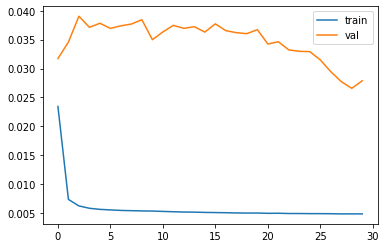

RMSE: 0.06939


In [64]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: {:.5f}'.format(rmse))

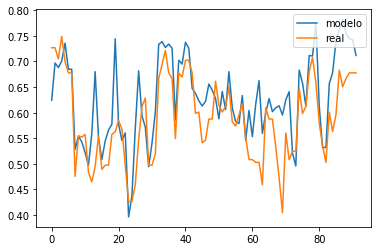

In [65]:
# Plotando a série predita e a série real
plt.plot(y_pred)
plt.plot(y_test)
plt.legend(['modelo', 'real'], loc='upper right')

Possível overfitting. O loss para a validação não está diminuindo de acordo com o loss para os dados de treino.

### Tentativa de RNN

In [66]:
rows = X_train.shape[0]
cols = X_train.shape[1]
X_train = X_train.reshape(rows, cols, 1)
rows = X_test.shape[0]
cols = X_test.shape[1]
X_test = X_test.reshape(rows, cols, 1)

In [67]:
model = Sequential()
model.add(SimpleRNN(32, input_shape = (X_train.shape[1], X_train.shape[2])))
model.add(Dense(16))
model.add(Dense(1))

model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse'])

history = model.fit(X_train, y_train, 
    epochs=35, batch_size=128, verbose=2, 
    validation_split = 0.20)

Epoch 1/35
403/403 - 8s - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0529 - val_mse: 0.0529
Epoch 2/35
403/403 - 9s - loss: 0.0067 - mse: 0.0067 - val_loss: 0.0521 - val_mse: 0.0521
Epoch 3/35
403/403 - 9s - loss: 0.0063 - mse: 0.0063 - val_loss: 0.0544 - val_mse: 0.0544
Epoch 4/35
403/403 - 9s - loss: 0.0060 - mse: 0.0060 - val_loss: 0.0482 - val_mse: 0.0482
Epoch 5/35
403/403 - 9s - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0441 - val_mse: 0.0441
Epoch 6/35
403/403 - 9s - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0417 - val_mse: 0.0417
Epoch 7/35
403/403 - 9s - loss: 0.0059 - mse: 0.0059 - val_loss: 0.0378 - val_mse: 0.0378
Epoch 8/35
403/403 - 8s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0309 - val_mse: 0.0309
Epoch 9/35
403/403 - 9s - loss: 0.0057 - mse: 0.0057 - val_loss: 0.0329 - val_mse: 0.0329
Epoch 10/35
403/403 - 9s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0285 - val_mse: 0.0285
Epoch 11/35
403/403 - 9s - loss: 0.0056 - mse: 0.0056 - val_loss: 0.0229 - val_mse: 0.0229
Epoch 12

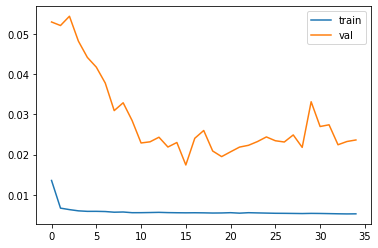

RMSE: 0.06900


In [68]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: {:.5f}'.format(rmse))

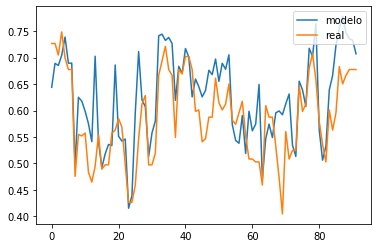

In [69]:
# Plotando a série predita e a série real
plt.plot(y_pred)
plt.plot(y_test)
plt.legend(['modelo', 'real'], loc='upper right')

O modelo apresenta um erro médio baixo. Porém, podemos observar que a série predita não acompanha os padrões dos valores reais em diversos pontos.

### Tentativa de LSTM

In [71]:
model = Sequential()
model.add(LSTM(50, input_shape = (X_train.shape[1], X_train.shape[2]), dropout=0.2))
model.add(Dense(32))
model.add(Dense(1))

model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse'])

history = model.fit(X_train, y_train, epochs=35, batch_size=128, verbose=2, validation_split=0.2)

Epoch 1/35
403/403 - 5s - loss: 0.0267 - mse: 0.0267 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 2/35
403/403 - 4s - loss: 0.0164 - mse: 0.0164 - val_loss: 0.0187 - val_mse: 0.0187
Epoch 3/35
403/403 - 4s - loss: 0.0158 - mse: 0.0158 - val_loss: 0.0230 - val_mse: 0.0230
Epoch 4/35
403/403 - 4s - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 5/35
403/403 - 4s - loss: 0.0153 - mse: 0.0153 - val_loss: 0.0222 - val_mse: 0.0222
Epoch 6/35
403/403 - 4s - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0244 - val_mse: 0.0244
Epoch 7/35
403/403 - 4s - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0250 - val_mse: 0.0250
Epoch 8/35
403/403 - 4s - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0233 - val_mse: 0.0233
Epoch 9/35
403/403 - 4s - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0214 - val_mse: 0.0214
Epoch 10/35
403/403 - 4s - loss: 0.0143 - mse: 0.0143 - val_loss: 0.0220 - val_mse: 0.0220
Epoch 11/35
403/403 - 4s - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0212 - val_mse: 0.0212
Epoch 12

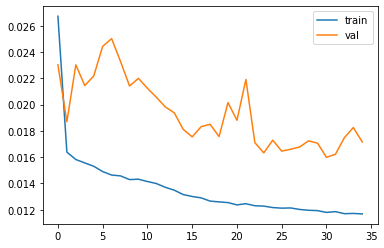

RMSE: 0.05597


In [72]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print('RMSE: {:.5f}'.format(rmse))

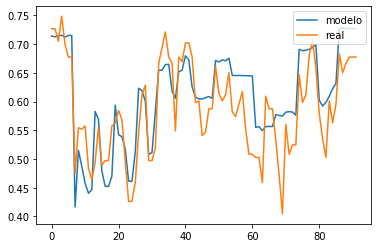

In [73]:
# Plotando a série predita e a série real
plt.plot(y_pred)
plt.plot(y_test)
plt.legend(['modelo', 'real'], loc='upper right')

### Continuar depois...

Em geral os modelos estão com um erro médio quadrático baixo, porém ao plotar as séries, observamos que os valores preditos não acompanham bem os padrões dos valores reais.

Quando se trabalha com séries temporais, é comum criar novas variáveis para o dataset considerando os valores anteriores da série (variáveis de lag) e medidas de tendência móveis (rolling). Podemos tentar adicionar estas variáveis ao conjunto de dados e verificar o desempenho.